In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
train_path = 'train_images/'
test_path = 'test_images/'
train_df = np.empty((30000, 28, 28), dtype=np.uint8)
test_df = np.empty((12000, 28, 28), dtype=np.uint8)
indx = 0
#Train images
while indx < 30000:
    image = Image.open(f"{train_path}{indx}.jpg")
    train_df[indx] = np.asarray(image)
    indx += 1
#Test images
while indx < 42000:
    image = Image.open(f"{test_path}{indx}.jpg")
    test_df[indx-30000] = np.asarray(image)
    indx += 1
#Labels
df = pd.read_csv('mnist_csv/train.csv')
label_matrix = np.eye(10, dtype=np.float32)
train_labels = np.array(list(map(lambda x: label_matrix[x], df.iloc[:30000, 0].to_numpy())))
test_labels = np.array(list(map(lambda x: label_matrix[x], df.iloc[30000:, 0].to_numpy())))
df = pd.DataFrame()

In [3]:
print(train_labels.shape)
test_labels.shape

(30000, 10)


(12000, 10)

In [4]:
#Data augmentation
import albumentations as A
import cv2

transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=0.25),
    A.ShiftScaleRotate(p=0.4, shift_limit=(-0.2, 0.2), scale_limit=(0, 0), rotate_limit=(0, 0), interpolation=cv2.INTER_NEAREST),
    # A.ShiftScaleRotate(p=1, shift_limit=(0, 0), scale_limit=(-0.2, 0.2), rotate_limit=(0, 0), interpolation=cv2.INTER_NEAREST),
    A.ShiftScaleRotate(p=0.25, shift_limit=(0, 0), scale_limit=(0, 0), rotate_limit=(-20, 20), interpolation=cv2.INTER_NEAREST)
])

transformed = np.copy(train_df)
for i in range(len(transformed)):
    transformed[i] = np.array(transform(image=transformed[i])['image'])

In [5]:
transformed.shape

(30000, 28, 28)

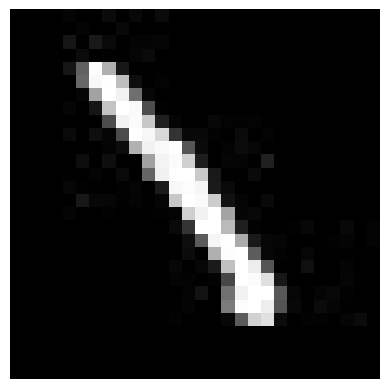

In [6]:
plt.imshow(transformed[0], cmap='gray')
# plt.imshow(train_df[0], cmap='gray')
plt.axis('off')  # Убираем оси координат
plt.show()

In [7]:
transformed_min_max = (transformed - transformed.min()) / (transformed.max() - transformed.min())
train_df_min_max = (train_df - train_df.min()) / (train_df.max() - train_df.min())
test_df_min_max = (test_df - train_df.min()) / (train_df.max() - train_df.min())

In [8]:
print(transformed_min_max.shape)
print(train_df_min_max.shape)
print(test_df_min_max.shape)

(30000, 28, 28)
(30000, 28, 28)
(12000, 28, 28)


In [24]:
class Simple_cnn(nn.Module):
    def __init__(self, training=True):
        super(Simple_cnn, self).__init__()
        self._training = training
        self.cnn_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.cnn_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(5*5*64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10),
            nn.Softmax()
        )
        
    def turn_training(self):
        self._training = not self._training
        print(f'Changed to: {self._training}!')
        
    def forward(self, x):
        if self._training is True:
            x = self.cnn_1(x)
            x = self.cnn_2(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x
        #Get maps
        else:
            x_1 = self.cnn_1(x)
            x_2 = self.cnn_2(x_1)
            return (x_1, x_2)

In [10]:
device = torch.device('cuda')
device.type

'cuda'

In [11]:
#Make dataset
class Step_dataset(Dataset):
    def __init__(self, data, labels):
        self.input = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        print(f'Input size: {len(self.input)}') 
        print(f'Labels size: {len(self.labels)}') 
    def __len__(self):
        return len(self.input)
    def __getitem__(self, indx):
        return self.input[indx], self.labels[indx]

In [12]:
train_dataset = Step_dataset(np.vstack([train_df_min_max, transformed_min_max]), np.vstack([train_labels, train_labels]))
test_dataset = Step_dataset(test_df_min_max, test_labels)

Input size: 60000
Labels size: 60000
Input size: 12000
Labels size: 12000


In [13]:
train_dataset[30002][1] == train_dataset[2][1]

tensor([True, True, True, True, True, True, True, True, True, True])

In [14]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)#, pin_memory=True, num_workers=4

In [15]:
class Accuracy():
    def __call__(self, y_pred, y):
        non_zero = (y - y_pred).count_nonzero().item()
        size = len(y)
        return (size - non_zero) / size

class Early_stop():
    def __init__(self, stop_after):
        self._stop_after = stop_after
        self._counter = 0
        self._old_accuracy = None
    def __call__(self, new_accuracy, model, path_model):
        if self._old_accuracy is None:
            self._old_accuracy = new_accuracy
            torch.save(model.state_dict(), path_model)
            return False
        if new_accuracy > self._old_accuracy:
            self._old_accuracy = new_accuracy
            self._counter = 0
            torch.save(model.state_dict(), path_model)
            return False
        else:
            self._counter += 1
            if self._counter > self._stop_after:
                return True
            else:
                return False

In [16]:
def validate(model, criterion, validate_dataset, device = torch.device('cuda')):
    model = model.eval()
    model.to(device)
    
    predictions = []
    y_true = []
    with torch.no_grad():
        for data, label in validate_dataset:
            data = data.unsqueeze(1).to(device)
            label = label.to(device)
            y_pred = model(data).to(device)
            predictions.append(torch.max(y_pred, dim=1)[1])
            y_true.append(torch.max(label, dim=1)[1])
        predictions = torch.cat(predictions)
        y_true = torch.cat(y_true)
        return criterion(predictions, y_true)

In [17]:
test_model = Simple_cnn()
test_criterion = nn.CrossEntropyLoss().cuda()
for data, label in train_loader:
    data = data.unsqueeze(1)
    y_pred = test_model(data)
    loss = test_criterion(y_pred, label) #Вычисление ошибки
    loss.backward()
    break
for param in test_model.parameters():
    print(param.grad.shape)
    print(param.shape)
    break

torch.Size([16, 1, 5, 5])
torch.Size([16, 1, 5, 5])


c:\Users\Zuzu\anaconda3\envs\ML_2\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda')
scnn = Simple_cnn().to(device)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(scnn.parameters(), lr=0.0004)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
accuracy = Accuracy()
stoper = Early_stop(25)

history = []
acc_history = []
for epoch in range(200):
    epoch_loss = 0.0
    for data, label in train_loader:
        data = data.unsqueeze(1).to(device)
        label = label.to(device)
        optimizer.zero_grad()               #Очистка градиента
        pred_label = scnn.forward(data)     #Прямой проход
        loss = criterion(pred_label, label) #Вычисление ошибки
        loss.backward()                     #Вычисление градиента по параметрам модели
        optimizer.step()                    #Изменение весов модели
        epoch_loss += loss.item()
    acc = validate(scnn, accuracy, test_loader)
    if stoper(acc, scnn, 'best_model_1') is True:
        print(f'Early stopped on {epoch} epoch!')
        break
    history.append(epoch_loss / len(train_loader))
    acc_history.append(acc)
    lr_scheduler.step(epoch_loss)
    print(f'Epoch {epoch} loss: {epoch_loss / len(train_loader)}, accuracy: {acc}')

c:\Users\Zuzu\anaconda3\envs\ML_2\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0 loss: 1.9651975591303938, accuracy: 0.90825
Epoch 1 loss: 1.6591351274716652, accuracy: 0.9570833333333333
Epoch 2 loss: 1.5968960200325917, accuracy: 0.9633333333333334
Epoch 3 loss: 1.5681924395642037, accuracy: 0.9653333333333334
Epoch 4 loss: 1.550233990459119, accuracy: 0.9690833333333333
Epoch 5 loss: 1.5367146791037867, accuracy: 0.9675833333333334
Epoch 6 loss: 1.528817817316217, accuracy: 0.97175
Epoch 7 loss: 1.5214952169838598, accuracy: 0.9726666666666667
Epoch 8 loss: 1.5141920982781103, accuracy: 0.9738333333333333
Epoch 9 loss: 1.5094549797349057, accuracy: 0.9750833333333333
Epoch 10 loss: 1.502768286203934, accuracy: 0.97575
Epoch 11 loss: 1.4976678884635537, accuracy: 0.9775
Epoch 12 loss: 1.4938835713822962, accuracy: 0.9803333333333333
Epoch 13 loss: 1.4893717361708818, accuracy: 0.9796666666666667
Epoch 14 loss: 1.4859348737587363, accuracy: 0.9784166666666667
Epoch 15 loss: 1.4850005557981587, accuracy: 0.98225
Epoch 16 loss: 1.4825255143440377, accuracy: 

In [ ]:
history

[1.8459939623283128,
 1.6387546577696073,
 1.5850897875882812,
 1.532276554632995,
 1.4854614865981925,
 1.4798553464776378,
 1.4778387162644984,
 1.4756129939677352,
 1.4731525253441373,
 1.4735083792169215,
 1.4719866665743164,
 1.4706907625925743,
 1.4690306378623186,
 1.468789984614162,
 1.4686513452206629,
 1.4689622976012149,
 1.4671096195608884,
 1.466068077895601,
 1.466112289388301,
 1.4658188537015753,
 1.4667367268416842,
 1.4654308224128465,
 1.4652601662328688,
 1.4645519943560583,
 1.4644839187799874,
 1.465758847988258,
 1.4644559258121554,
 1.4642635583877563,
 1.4647405248577312,
 1.4644136550062794,
 1.4641266677339198,
 1.4646542880494715,
 1.4638973898806815,
 1.4634982488923154,
 1.4636316521693085,
 1.464137338985831,
 1.4638482524176775,
 1.4645447660300692,
 1.46475234173112,
 1.4637656898821814,
 1.4632141478991105,
 1.4630204277523493,
 1.4634065062312756,
 1.4630575705382785,
 1.462944918769901,
 1.4629929490008597,
 1.46283707275229,
 1.4634181937928927,
 1.

In [26]:
model = Simple_cnn()
model = model.eval()
model.load_state_dict(torch.load('best_model_1'))
acc = validate(model, accuracy, test_loader)
print(acc)
#0.9913333333333333 - base scnn model with Adam and scheduler
#0.9914166666666666 - dropout = 0.5 with Adam and scheduler
#0.992 - +batch normalization with increase lr x2 (but i need x2 epochs for convergence)
#0.98875 - augm
#0.9869166666666667 - thin + augm

0.9869166666666667


In [157]:
test_dataset[0][0].unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [218]:
with torch.no_grad():
    model.turn_training()
    predict = model(test_dataset[0][0].unsqueeze(0).unsqueeze(0).to(device))
    print(predict)
    layer_1_map = np.array(predict[0].to('cpu'))
    layer_2_map = np.array(predict[1].to('cpu'))

Changed to: False!
(tensor([[[[0.1210, 0.1202, 0.4405,  ..., 0.1860, 0.0512, 0.1127],
          [0.3894, 1.1741, 1.0142,  ..., 0.1313, 0.0706, 0.1043],
          [0.3480, 2.0683, 1.5558,  ..., 0.0000, 0.0808, 0.1028],
          ...,
          [0.1630, 1.7203, 2.3967,  ..., 0.6720, 0.0000, 0.0723],
          [0.2216, 0.4655, 1.0920,  ..., 0.0000, 0.0000, 0.1164],
          [0.1396, 0.2284, 0.4142,  ..., 0.0000, 0.0841, 0.0904]],

         [[0.3576, 0.2809, 0.5439,  ..., 0.5236, 0.3861, 0.3485],
          [0.4738, 0.4937, 0.3501,  ..., 0.5722, 0.3890, 0.3827],
          [0.8933, 0.5632, 0.6964,  ..., 0.4901, 0.3429, 0.3429],
          ...,
          [0.4587, 2.0293, 1.6894,  ..., 0.9554, 0.0000, 0.3629],
          [0.3919, 1.5235, 2.9338,  ..., 0.1493, 0.0000, 0.6440],
          [0.3759, 0.3453, 0.7998,  ..., 0.5793, 0.7247, 0.3326]],

         [[0.5008, 0.5631, 0.7911,  ..., 0.3508, 0.4552, 0.5282],
          [0.7077, 1.4110, 2.0914,  ..., 0.4611, 0.4885, 0.5549],
          [0.9474, 1.6

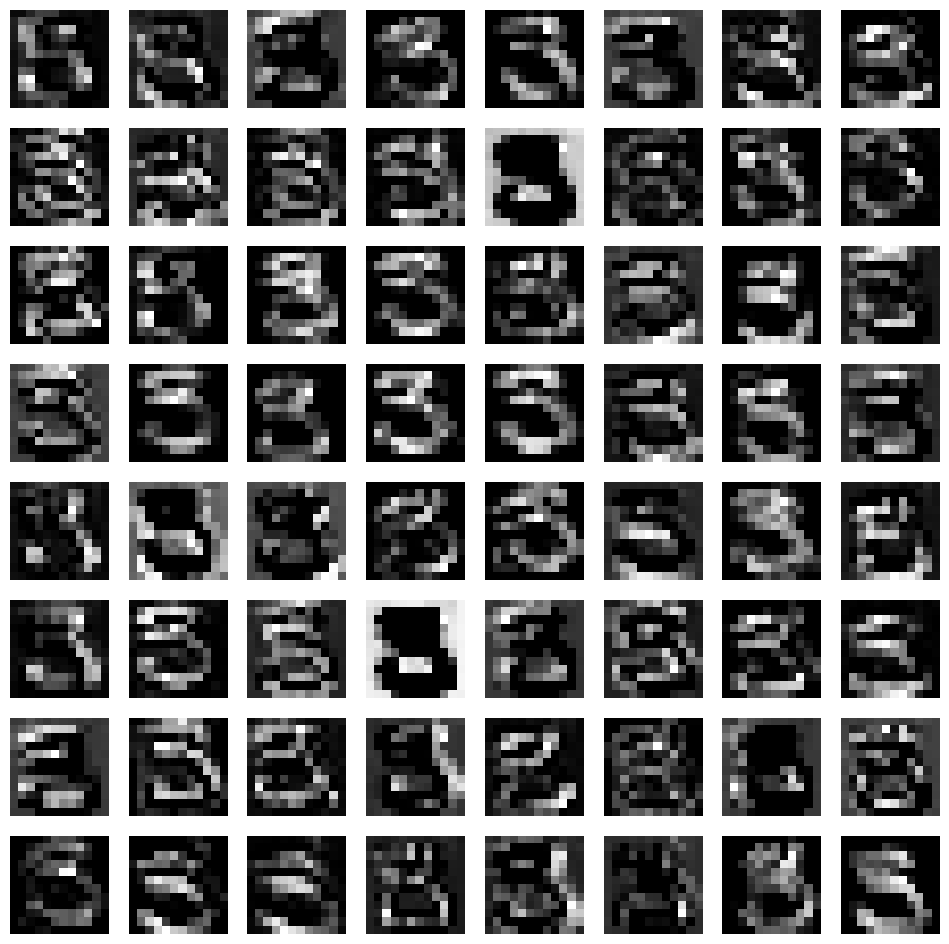

In [219]:
# Строим изображение из массива массивов
layer_1_map_buff = np.squeeze(layer_1_map)

fig, axes = plt.subplots(8, 8, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(layer_1_map_buff[i], cmap='gray')  # Отображаем каждое изображение в ячейке сетки
    ax.axis('off')  # Отключаем оси
plt.show()

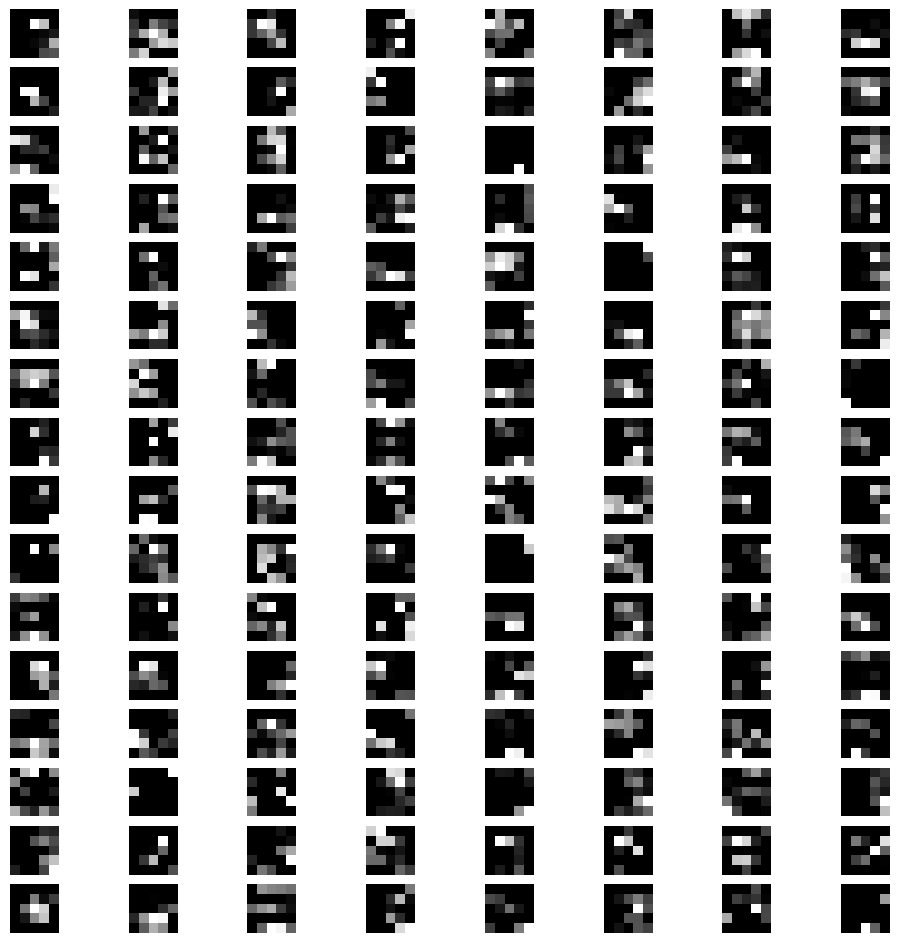

In [220]:
# Строим изображение из массива массивов
layer_2_map_buff = np.squeeze(layer_2_map)

fig, axes = plt.subplots(16, 8, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(layer_2_map_buff[i], cmap='gray')  # Отображаем каждое изображение в ячейке сетки
    ax.axis('off')  # Отключаем оси
plt.show()